# Toy study: Gaussian on a circle

## Setup

In [2]:
import sys
from collections import OrderedDict
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import torch
from torch.utils.data import TensorDataset
import logging

sys.path.append("../../")
from manifold_flow import transforms, utils, distributions, training
from manifold_flow.flows import Flow, ManifoldFlow
from manifold_flow import nn as nn_
from experiments.simulators.spherical_simulator import SphericalGaussianSimulator
from experiments.utils.models import create_vector_transform

%matplotlib inline

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "experiments" not in key and "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


### Settings

In [7]:
epochs = 120
n_train = 10000
epsilon = 0.01
train = False

### Data

In [4]:
simulator = SphericalGaussianSimulator(latent_dim=1, data_dim=2, epsilon=epsilon)
x_sim = simulator.sample(n_train)
x_sim_tensor = torch.from_numpy(x_sim)
train_dataset = TensorDataset(x_sim_tensor, x_sim_tensor)

In [5]:
# res = 200
# x_range = np.linspace(-1.4,1.4,res)
# y_range = np.linspace(-1.4,1.4,res)
# xx, yy = np.meshgrid(x_range, y_range)
# x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
# logp_grid = simulator.log_density(x_grid, precise=True).reshape((res, res))
# logp_grid[~np.isfinite(logp_grid)] = -1000000.

# zmin, zmax = np.max(logp_grid) - 10, np.max(logp_grid)
# fig = plt.figure(figsize=(5,4))
# ax = plt.gca()

# pcm = plt.imshow(
#     np.clip(logp_grid, zmin, zmax),
#     extent=(-1.4,1.4,-1.4,1.4),
#     origin="lower",
#     cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax),
#     interpolation='nearest'
# )
# cb = plt.colorbar(pcm, extend="both")
# plt.scatter(x_sim[::50,0], x_sim[::50,1], s=2., c="black", alpha=1.)

# plt.xlabel("$x_1$")
# plt.ylabel("$x_2$")
# cb.set_label("$\log \; p(x)$")
# plt.tight_layout()

# plt.savefig("../figures/simulator_toy.pdf", dpi=500)

# pixel_size = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])

# print("Integral over density =", np.sum(np.exp(logp_grid) * pixel_size))

## Set up models

In [6]:
labels = OrderedDict()
labels["truth"] = "Truth"
labels["sf"] = "EF"
labels["pie"] = "PIE (manifold)"
labels["pie_full"] = "PIE"
labels["mf"] = "MF"
labels["mlfl"] = "MLF-L"
labels["mlfa"] = "MLF-A"
labels["mlfot"] = "MLF-OT"
labels["mlfae"] = "MLF-AE"


### Standard flow

In [9]:
sf = Flow(
    data_dim=2,
    transform=create_vector_transform(2, 10, base_transform_type="affine-coupling"),
)

if train:
    trainer = training.trainer.ManifoldFlowTrainer(sf)
    trainer.train(
        train_dataset,
        [training.losses.nll],
        loss_weights=[1.],
        epochs=epochs,
    )
    torch.save(sf.state_dict(), "../data/models/sf_toy.pt")
else:
    sf.load_state_dict(torch.load("../data/models/sf_toy.pt"))

### Manifold flow (with specified manifold)

In [11]:
mf = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=transforms.ConditionalAffineScalarTransform(features=1),
    outer_transform=transforms.SphericalCoordinates(n=1, r0=1., azimuthal_offset=-0.5*np.pi)
)

if train:
    trainer = training.trainer.ManifoldFlowTrainer(mf)
    trainer.train(
        train_dataset,
        [training.losses.nll],
        loss_weights=[1.],
        epochs=epochs,
        forward_kwargs={"mode":"mf"}
    )
    torch.save(mf.state_dict(), "../data/models/mf_toy.pt")
else:
    mf.load_state_dict(torch.load("../data/models/mf_toy.pt"))

### PIE

In [13]:
pie = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    outer_transform=create_vector_transform(2, 5, base_transform_type="affine-coupling"),
    inner_transform=transforms.ConditionalAffineScalarTransform(features=1),
    pie_epsilon=0.1,
)

if train:
    trainer = training.trainer.ManifoldFlowTrainer(pie)
    trainer.train(
        train_dataset,
        [training.losses.nll],
        loss_weights=[1.],
        epochs=epochs,
        forward_kwargs={"mode":"pie"}
    )
    torch.save(pie.state_dict(), "../data/models/pie_toy.pt")
else:
    pie.load_state_dict(torch.load("../data/models/pie_toy.pt"))
    

17:05 manifold_flow.training.trainer INFO    Training on CPU with single precision
17:05 manifold_flow.training.trainer INFO    Epoch   6: train loss -0.07766 (nll: -0.078)
17:05 manifold_flow.training.trainer INFO               val. loss  -0.23928 (nll: -0.239)
17:05 manifold_flow.training.trainer INFO    Epoch  12: train loss -0.29530 (nll: -0.295)
17:05 manifold_flow.training.trainer INFO               val. loss  -0.42009 (nll: -0.420)
17:05 manifold_flow.training.trainer INFO    Epoch  18: train loss -0.30366 (nll: -0.304)
17:05 manifold_flow.training.trainer INFO               val. loss  -0.37152 (nll: -0.372)
17:05 manifold_flow.training.trainer INFO    Epoch  24: train loss -0.24041 (nll: -0.240)
17:05 manifold_flow.training.trainer INFO               val. loss   0.01063 (nll:  0.011)
17:06 manifold_flow.training.trainer INFO    Epoch  30: train loss -0.46284 (nll: -0.463)
17:06 manifold_flow.training.trainer INFO               val. loss  -0.51755 (nll: -0.518)
17:06 manifold_fl

### MLF-L

In [14]:
# mlfl = ManifoldFlow(
#     data_dim=2,
#     latent_dim=1,
#     inner_transform=transforms.ConditionalAffineScalarTransform(features=1),
#     outer_transform=create_vector_transform(2, 3, base_transform_type="affine-coupling")
# )

# if train:
#     trainer = training.trainer.ManifoldFlowTrainer(mlfl)
#     trainer.train(
#         train_dataset,
#         [training.losses.mse],
#         loss_weights=[100.],
#         epochs=epochs // 3,
#         forward_kwargs={"mode":"projection"}
#     )
#     trainer.train(
#         train_dataset,
#         [training.losses.mse, training.losses.nll],
#         loss_weights=[100., 0.1],
#         epochs=epochs // 3,
#         forward_kwargs={"mode":"mf"}
#     )
#     trainer.train(
#         train_dataset,
#         [training.losses.mse, training.losses.nll],
#         loss_weights=[0., 1.],
#         epochs=epochs // 3,
#         parameters=mf.inner_transform.parameters(),
#         forward_kwargs={"mode":"mf"}
#     )
#     torch.save(mlfl.state_dict(), "../data/models/mlfl_toy.pt")
# else:
#     mlfl.load_state_dict(torch.load("../data/models/mlfl_toy.pt"))

### MLF-A

In [15]:
mlfa = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=transforms.ConditionalAffineScalarTransform(features=1),
    outer_transform=create_vector_transform(2, 5, base_transform_type="affine-coupling")
)

if train:
    trainer = training.ManifoldFlowTrainer(mlfa)
    metatrainer = training.AlternatingTrainer(mlfa, trainer, trainer)
    metatrainer.train(
        train_dataset,
        loss_functions=[training.losses.mse, training.losses.nll],
        loss_function_trainers=[0, 1],
        loss_labels=["MSE", "NLL"],
        loss_weights=[100., 0.1],
        epochs=epochs,
        parameters=[mlfa.parameters(), mlfa.inner_transform.parameters()],
        trainer_kwargs=[{"forward_kwargs": {"mode": "projection"}}, {"forward_kwargs": {"mode": "pie"}}],
    )
    torch.save(mlfa.state_dict(), "../data/models/mlfa_toy.pt")
else:
    mlfa.load_state_dict(torch.load("../data/models/mlfa_toy.pt"))

### MLF-OT

In [16]:
mlfot = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=transforms.ConditionalAffineScalarTransform(features=1),
    outer_transform=create_vector_transform(2, 5, base_transform_type="affine-coupling")
)

if train:
    trainer = training.trainer.GenerativeTrainer(mlfot)
    trainer.train(
        train_dataset,
        [training.losses.make_sinkhorn_divergence()],
        loss_weights=[100.],
        epochs=epochs,
        batch_size=1000,
    )
    torch.save(mlfot.state_dict(), "../data/models/mlfot_toy.pt")
else:
    mlfot.load_state_dict(torch.load("../data/models/mlfot_toy.pt"))

### MLF-AE

In [17]:
mlfae = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=transforms.ConditionalAffineScalarTransform(features=1),
    outer_transform=create_vector_transform(2, 5, base_transform_type="affine-coupling")
)

if train:
    trainer = training.trainer.ManifoldFlowTrainer(mlfae)
    trainer.train(
        train_dataset,
        [training.losses.mse],
        loss_weights=[100.],
        epochs=epochs,
        forward_kwargs={"mode":"projection"}
    )
    torch.save(mlfae.state_dict(), "../data/models/mlfae_toy.pt")
else:
    mlfae.load_state_dict(torch.load("../data/models/mlfae_toy.pt"))

## Evaluate the models

In [18]:
sf.eval()
mf.eval()
pie.eval()
# mlfl.eval()
mlfa.eval()
mlfot.eval()
mlfae.eval()

ManifoldFlow(
  (manifold_latent_distribution): StandardNormal()
  (orthogonal_latent_distribution): RescaledNormal()
  (projection): ProjectionSplit()
  (outer_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): CompositeTransform(
        (_transforms): ModuleList(
          (0): RandomPermutation()
          (1): AffineCouplingTransform(
            (transform_net): ResidualNet(
              (initial_layer): Linear(in_features=1, out_features=100, bias=True)
              (blocks): ModuleList(
                (0): ResidualBlock(
                  (linear_layers): ModuleList(
                    (0): Linear(in_features=100, out_features=100, bias=True)
                    (1): Linear(in_features=100, out_features=100, bias=True)
                  )
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (1): ResidualBlock(
                  (linear_layers): ModuleList(
                    (0): Linear(in_features=100, out_fea

### Sample from models

In [20]:
x_gen = OrderedDict()

x_gen["truth"] = x_sim[:1000]
x_gen["sf"] = sf.sample(n=1000).detach().numpy()
x_gen["mf"] = mf.sample(n=1000).detach().numpy()
x_gen["pie"] = pie.sample(n=1000).detach().numpy()
x_gen["pie_full"] = pie.sample(n=1000, sample_orthogonal=True).detach().numpy()
# x_gen["mlfl"] = mlfl.sample(n=1000).detach().numpy()
x_gen["mlfa"] = mlfa.sample(n=1000).detach().numpy()
x_gen["mlfot"] = mlfot.sample(n=1000).detach().numpy()
x_gen["mlfae"] = mlfae.sample(n=1000).detach().numpy()


### Evaluate model likelihood over data space

In [21]:
res = 200
boundary = 1.5
im_extent = boundary + 0.5 * (2.*boundary/(res - 1))

x_range = np.linspace(-boundary, boundary, res)
y_range = np.linspace(-boundary, boundary, res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
x_grid_tensor = torch.FloatTensor(x_grid)


logp_grid = OrderedDict()
logp_grid["truth"] = simulator.log_density(x_grid).reshape((res, res))
logp_grid["truth"][~np.isfinite(logp_grid["truth"])] = -1000000.
logp_grid["sf"] = sf.log_prob(x_grid_tensor).detach().numpy().reshape((res, res))
logp_grid["pie_full"] = pie.log_prob(x_grid_tensor, mode="pie").detach().numpy().reshape((res, res))


../../experiments/simulators/spherical_simulator.py:105: RuntimeWarning: divide by zero encountered in log
  logp_eps = np.log(norm(loc=0.0, scale=self._epsilon).pdf(z_eps))


In [22]:
def likelihood_along_manifold(model, mode="mf", zmin=-50., zmax=50., n_samples=1000, epsilon=0.02, max_insert=100):
    # Sample
    u = torch.linspace(zmin, zmax, n_samples).view(-1,1)
    x = model.sample(n=n_samples, u=u).detach().numpy()
    u = u.numpy().flatten()
    
    def in_box(x):
        return np.abs(x[0]) < 1.5 or np.abs(x[1]) < 1.5
    
    # Interpolate
    x_interpol = [x[0]]
    for x_prev, x_now, u_prev, u_now  in zip(x[:-1], x[1:], u[:-1], u[1:]):
        
        # Check if we should generate more points in between
        distance = np.linalg.norm(x_now-x_prev)
        if distance > epsilon and (in_box(x_now) or in_box(x_prev)):
            n_insert = min(int(distance / epsilon), max_insert)
            u_insert = torch.linspace(u_prev, u_now, n_insert + 2)[1:-1].view(-1,1)
            x_insert = model.sample(n=n_insert, u=u_insert).detach().numpy()
            for x_ in x_insert:
                if in_box(x_):
                    x_interpol.append(x_)
            
        if in_box(x_now):
            x_interpol.append(x_now)
            
    x_interpol = np.array(x_interpol)

    # Evaluate likelihood
    log_probs = model.log_prob(torch.FloatTensor(x_interpol), mode=mode).detach().numpy()

    # Return
    return x_interpol, log_probs


logp_manifold, x_manifold = OrderedDict(), OrderedDict()
x_manifold["mf"], logp_manifold["mf"] = likelihood_along_manifold(mf)
# x_manifold["mlfl"], logp_manifold["mlfl"] = likelihood_along_manifold(mlfl)
x_manifold["mlfa"], logp_manifold["mlfa"] = likelihood_along_manifold(mlfa)
x_manifold["mlfot"], logp_manifold["mlfot"] = likelihood_along_manifold(mlfot)
x_manifold["mlfae"], logp_manifold["mlfae"] = likelihood_along_manifold(mlfae)


### Calculate metrics for generated samples: mean distance from manifold, true likelihood

In [23]:
def generative_metrics(x, logp_min=-100., d_max=1., summary_fn=np.mean):
    logp_gen = simulator.log_density(x)
    logp_gen[(~np.isfinite(logp_gen)) + (logp_gen<logp_min)] = logp_min
    logp_summary = summary_fn(logp_gen)
    
    d_gen = np.abs(np.sum(x**2, axis=1)**0.5 - 1)
    d_gen[(~np.isfinite(d_gen)) + (d_gen>d_max)] = d_max
    d_summary = summary_fn(d_gen)
    
    return logp_summary, d_summary


logp_gen, d_gen = OrderedDict(), OrderedDict()

for key, val in x_gen.items():
    logp_gen[key], d_gen[key] = generative_metrics(x_gen[key])
    

print("Mean true log likelihood of samples generated from flows (higher is better):")
for key, val in logp_gen.items():
    print("  {:>10.10s}: {:>6.1f}".format(key, val))
    
print("Mean Euclidean distance between samples generated from flows and true manifold (lower is better):")
for key, val in d_gen.items():
    print("  {:>10.10s}: {:>6.4f}".format(key, val))
    

Mean true log likelihood of samples generated from flows (higher is better):
       truth:    2.0
          sf:  -84.9
          mf:    2.4
         pie:    1.3
    pie_full:  -24.3
        mlfa:   -5.4
       mlfot:    1.2
       mlfae:  -19.3
Mean Euclidean distance between samples generated from flows and true manifold (lower is better):
       truth: 0.0080
          sf: 0.5850
          mf: 0.0000
         pie: 0.0148
    pie_full: 0.1302
        mlfa: 0.0389
       mlfot: 0.0072
       mlfae: 0.1373


../../experiments/simulators/spherical_simulator.py:108: RuntimeWarning: divide by zero encountered in log
  log_det += np.sum(np.arange(self._latent_dim - 1, -1, -1)[np.newaxis, :] * np.log(np.abs(np.sin(z_phi))), axis=1)
../../experiments/simulators/spherical_simulator.py:108: RuntimeWarning: invalid value encountered in multiply
  log_det += np.sum(np.arange(self._latent_dim - 1, -1, -1)[np.newaxis, :] * np.log(np.abs(np.sin(z_phi))), axis=1)
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


### Visualize generated samples

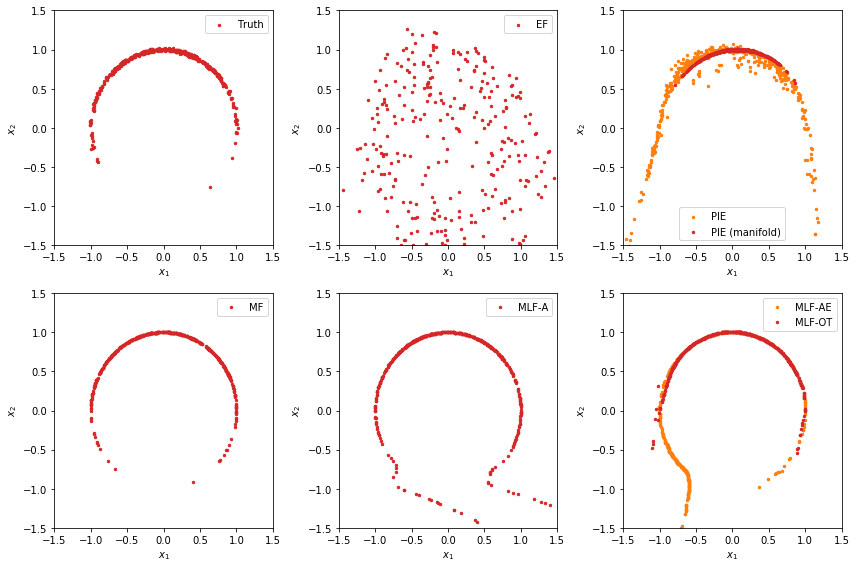

In [27]:
n = 500
show1 = ["truth", "sf", "pie", "mf", "mlfa", "mlfot"]
show2 = [None, None, "pie_full", None, None, "mlfae"]

fig = plt.figure(figsize=(4.*3,4.*2))

for i, (key, key2) in enumerate(zip(show1, show2)):
    ax = plt.subplot(2,3,i+1)
    
    if key2 is not None:
        plt.scatter(x_gen[key2][:n,0], x_gen[key2][:n,1], s=6., c="C1", label=labels[key2])
    plt.scatter(x_gen[key][:n,0], x_gen[key][:n,1], s=6., c="C3", label=labels[key])
    plt.legend()

    plt.xlim(-boundary, boundary)
    plt.ylim(-boundary, boundary)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")

plt.tight_layout()
plt.savefig("../figures/generated_samples_toy.pdf")


### Plot likelihoods

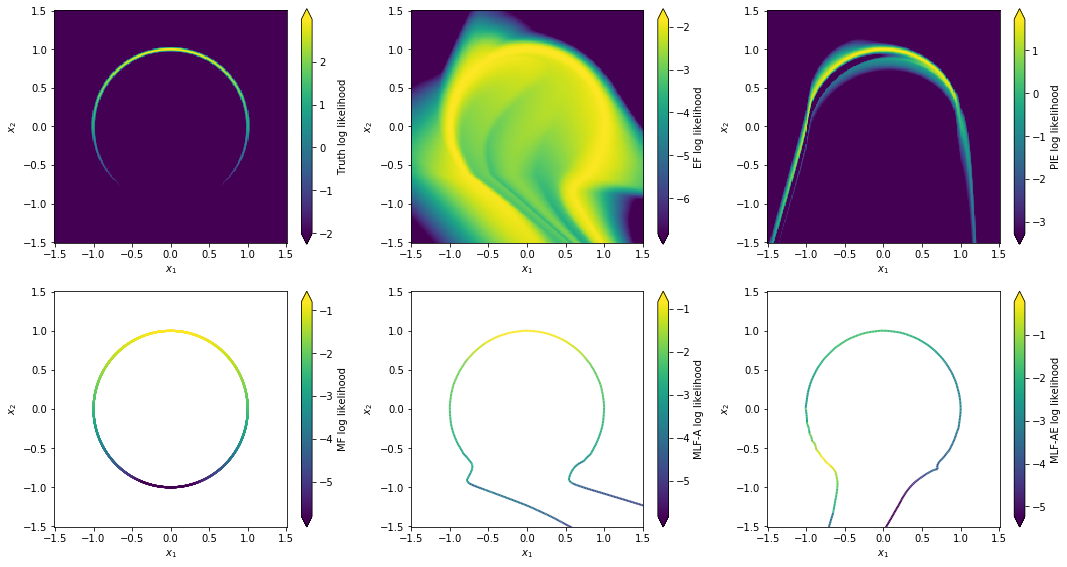

In [30]:
show = ["truth", "sf", "pie_full", "mf", "mlfa", "mlfae"]

fig = plt.figure(figsize=(5.*3,4.*2))

for i, key in enumerate(show):
    ax = plt.subplot(2,3,i+1)
    
    try:
        x = x_manifold[key]
        logp = logp_manifold[key]
        zmin, zmax = np.max(logp) - 5., np.max(logp)
        
        segments = np.concatenate([x[:-1,np.newaxis,:], x[1:,np.newaxis,:]], axis=1)
        lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(zmin, zmax))
        lc.set_array(np.clip(logp, zmin, zmax))
        lc.set_linewidth(2)
        im = ax.add_collection(lc)

    except KeyError:
        logp = logp_grid[key]
        zmin, zmax = np.max(logp) - 5., np.max(logp)
        im = plt.imshow(
            np.clip(logp, zmin, zmax),
            extent=(-im_extent, im_extent, -im_extent, im_extent),
            origin="lower",
            cmap="viridis",
            norm=matplotlib.colors.Normalize(zmin, zmax),
            interpolation='nearest'
        )
    cb = plt.colorbar(im, extend="both")

    plt.xlim(-im_extent, im_extent)
    plt.ylim(-im_extent, im_extent)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    cb.set_label(r"{} log likelihood".format(labels[key]))
    
plt.tight_layout()
plt.savefig("../figures/log_likelihood_toy.pdf", dpi=600)


## Other plots (not updated to new conventions yet)

### Plot reconstruction performance

In [ ]:
# x_in = SphericalGaussianSimulator(1,2,epsilon=10*epsilon).sample(100)
# x_in = torch.FloatTensor(x_in)
# x_out = mf(x_in)[0]
# x_in, x_out = x_in.detach().numpy(), x_out.detach().numpy()
# dx = x_out - x_in

In [ ]:
# fig = plt.figure(figsize=(5,5))
# ax = plt.gca()
# plt.scatter(x_in[:,0], x_in[:,1], s=15., c="C1")
# plt.scatter(x_out[:,0], x_out[:,1], s=15., c="C0")
# plt.quiver(
#     x_in[:,0], x_in[:,1], dx[:,0], dx[:,1],
#     angles='xy', scale_units='xy', scale=1., width=2.e-3, alpha=1.
# )

# plt.xlim(-1.5,1.5)
# plt.ylim(-1.5,1.5)
# plt.xlabel("$x_1$")
# plt.ylabel("$x_2$")
# plt.tight_layout()

# plt.savefig("../figures/spherical_gaussian_2d_mf_reco.pdf")


### Model anatomy

In [ ]:
# def make_anatomy_plot(model, name, res=25):
#     x_range = np.linspace(-1.5,1.5,res)
#     y_range = np.linspace(-1.5,1.5,res)
#     xx, yy = np.meshgrid(x_range, y_range)
#     x = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
#     x = torch.FloatTensor(x)
#     x.requires_grad = True

#     # Encode
#     u, h_manifold, h_orthogonal, log_det_outer, log_det_inner = model._encode(x)

#     # Decode
#     x_reco, _, _, inv_jacobian_outer = model._decode(u, mode="mf")
#     _, inv_log_det_inner, inv_log_det_outer, _ = model._decode(u, mode="slice")

#     # inv_jacobian_outer is dx / du, but still need to restrict this to the manifold latents
#     inv_jacobian_outer = inv_jacobian_outer[:, :, : model.latent_dim]
#     # And finally calculate log det (J^T J)
#     jtj = torch.bmm(torch.transpose(inv_jacobian_outer, -2, -1), inv_jacobian_outer)
#     mf_log_det_outer = - 0.5 * torch.slogdet(jtj)[1]

#     # Base log prob
#     log_prob_latent = model.manifold_latent_distribution._log_prob(u, context=None)
    
#     # Plot
#     fig = plt.figure(figsize=(12,9))

#     for panel, (label, quantity, diverging) in enumerate(zip(
#         ["Perp latent", "Manifold latent after outer flow", "Manifold latent after inner flow",
#          "log det outer (PIE)", "log det inner", "Base log prob",
#          "log det outer (MF)", "log det outer (Slice of PIE)", "delta log det outer (MF - Slice)"],
#         [h_orthogonal, h_manifold, u,
#          log_det_outer, - log_det_inner, log_prob_latent,
#          mf_log_det_outer, - inv_log_det_outer, mf_log_det_outer + inv_log_det_outer],
#         [True, True, True, False, False, False, False, False, False]
#     )):
#         ax = plt.subplot(3,3,panel+1)

#         quantity_ = quantity.detach().numpy()
#         quantity_ = quantity_.flatten() + np.zeros((res**2))

#         if diverging:
#             zmin, zmax = - 2. * np.std(quantity_), 2. * np.std(quantity_)
#         else:
#             zmin, zmax = np.mean(quantity_) - 1.5 * np.std(quantity_), np.mean(quantity_) + 1.5 * np.std(quantity_)

#         pcm = plt.imshow(
#             np.clip(quantity_, zmin, zmax).reshape(res, res),
#             extent=(-1.5, 1.5, -1.5, 1.5),
#             origin="lower",
#             cmap="PRGn" if diverging else "viridis",
#             norm=matplotlib.colors.Normalize(zmin, zmax),
#             interpolation='nearest'
#         )
#         cb = plt.colorbar(pcm, extend="both")
#         # plt.scatter(x_gen_mf[::10,0], x_gen_mf[::10,1], s=3., c="black")

#         plt.xlim(-1.5,1.5)
#         plt.ylim(-1.5,1.5)
#         plt.xlabel("$x_1$")
#         plt.ylabel("$x_2$")
#         cb.set_label(label)
#         plt.tight_layout()

#     plt.savefig("../figures/spherical_gaussian_2d_{}_anatomy.pdf".format(name))